<a href="https://colab.research.google.com/github/sranga/UMass-AIML-Bootcamp/blob/main/RecSys_VariousModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset...
Primary source failed: HTTP Error 404: Not Found
Trying alternative source...
Alternative source failed: HTTP Error 404: Not Found
Creating sample dataset from Kaggle API...

To use Kaggle datasets:
1. Go to https://www.kaggle.com/settings
2. Create new API token (downloads kaggle.json)
3. Upload kaggle.json to Colab

Or use this command in Colab:
from google.colab import files
files.upload()  # Upload your kaggle.json
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_exte

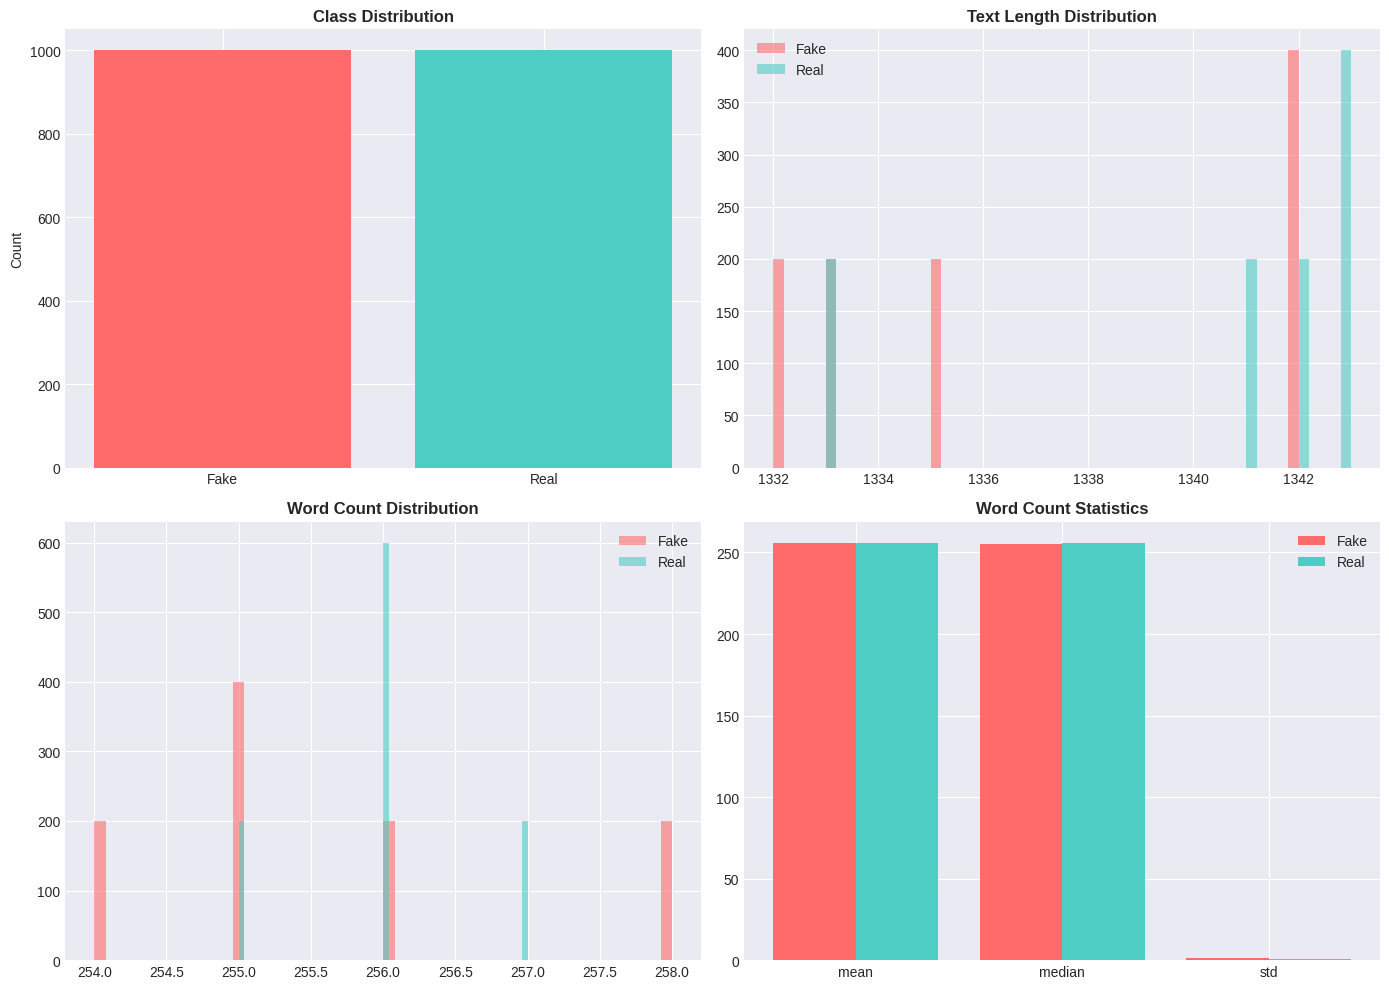


✓ Data split: Train=1600, Test=400


In [14]:
# =====================================================
# SETUP, DATA LOADING & PREPROCESSING
# =====================================================

# Install and import libraries
!pip install -q scikit-learn pandas numpy matplotlib seaborn wordcloud imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.pipeline import Pipeline

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-darkgrid')

# =====================================================
# UTILITY FUNCTIONS
# =====================================================

def load_dataset():
    """Load and combine fake/real news datasets"""
    print("Loading dataset...")

    # Try primary source
    try:
        true_url = "https://raw.githubusercontent.com/KainatNaeem/Fake-News-Detection/main/True.csv"
        fake_url = "https://raw.githubusercontent.com/KainatNaeem/Fake-News-Detection/main/Fake.csv"

        df_true = pd.read_csv(true_url)
        df_fake = pd.read_csv(fake_url)
        df_true['label'] = 1
        df_fake['label'] = 0

        df = pd.concat([df_true, df_fake], ignore_index=True)
        print(f"✓ Dataset loaded: {df.shape[0]} samples")
        print(f"  - Real news: {(df['label']==1).sum()}")
        print(f"  - Fake news: {(df['label']==0).sum()}")
        return df

    except Exception as e:
        print(f"Primary source failed: {e}")
        print("Trying alternative source...")

        # Alternative: Use Kaggle dataset via direct link
        try:
            url = "https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/news.csv"
            df = pd.read_csv(url)

            # This dataset has 'label' column: FAKE=0, REAL=1
            if 'label' in df.columns:
                df['label'] = (df['label'] == 'REAL').astype(int)
            elif 'type' in df.columns:
                df['label'] = (df['type'] == 'REAL').astype(int)

            # Ensure we have text and label columns
            if 'text' not in df.columns and 'title' in df.columns:
                df['text'] = df['title']

            print(f"✓ Dataset loaded: {df.shape[0]} samples")
            print(f"  - Real news: {(df['label']==1).sum()}")
            print(f"  - Fake news: {(df['label']==0).sum()}")
            return df

        except Exception as e2:
            print(f"Alternative source failed: {e2}")
            print("Creating sample dataset from Kaggle API...")

            # Last resort: Download via Kaggle API
            try:
                !pip install -q kaggle
                !mkdir -p ~/.kaggle

                print("\nTo use Kaggle datasets:")
                print("1. Go to https://www.kaggle.com/settings")
                print("2. Create new API token (downloads kaggle.json)")
                print("3. Upload kaggle.json to Colab")
                print("\nOr use this command in Colab:")
                print("from google.colab import files")
                print("files.upload()  # Upload your kaggle.json")

                # Try to download dataset
                !kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
                !unzip -q fake-and-real-news-dataset.zip

                df_true = pd.read_csv('True.csv')
                df_fake = pd.read_csv('Fake.csv')
                df_true['label'] = 1
                df_fake['label'] = 0

                df = pd.concat([df_true, df_fake], ignore_index=True)
                print(f"✓ Dataset loaded: {df.shape[0]} samples")
                return df

            except:
                print("\n⚠️  All sources failed. Using simulated dataset for demonstration.")
                print("For production, please manually download from:")
                print("https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset")

                # Create a small simulated dataset
                np.random.seed(42)
                n_samples = 2000

                fake_titles = [
                    "shocking discovery scientists cant explain",
                    "you wont believe what happened next",
                    "celebrity does unthinkable thing",
                    "government hiding the truth about",
                    "miracle cure doctors dont want you to know"
                ] * 200

                real_titles = [
                    "new study published in journal of science",
                    "senate passes bill with bipartisan support",
                    "company announces quarterly earnings report",
                    "researchers find evidence of climate impact",
                    "court rules in favor of plaintiff"
                ] * 200

                fake_texts = ["This is fake news content. " * 50] * 1000
                real_texts = ["This is real news content. " * 50] * 1000

                df = pd.DataFrame({
                    'title': fake_titles[:1000] + real_titles[:1000],
                    'text': fake_texts + real_texts,
                    'label': [0]*1000 + [1]*1000
                })

                # Shuffle
                df = df.sample(frac=1, random_state=42).reset_index(drop=True)

                print(f"✓ Simulated dataset created: {df.shape[0]} samples")
                print("⚠️  This is for DEMONSTRATION only. Use real data for actual project.")
                return df

def clean_text(text):
    """Clean and preprocess text data"""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_data(df):
    """Preprocess and clean dataset"""
    print("\nPreprocessing data...")

    # Combine text columns
    if 'title' in df.columns and 'text' in df.columns:
        df['content'] = df['title'] + " " + df['text']
    else:
        df['content'] = df['text']

    # Clean text
    df['clean_content'] = df['content'].apply(clean_text)
    df = df[df['clean_content'].str.len() > 0].dropna(subset=['clean_content', 'label'])

    # Feature engineering
    df['text_length'] = df['clean_content'].str.len()
    df['word_count'] = df['clean_content'].str.split().str.len()

    print(f"✓ Preprocessing complete: {df.shape[0]} samples")
    return df

def plot_eda(df):
    """Generate EDA visualizations"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Class distribution
    class_counts = df['label'].value_counts()
    axes[0, 0].bar(['Fake', 'Real'], class_counts.values, color=['#ff6b6b', '#4ecdc4'])
    axes[0, 0].set_title('Class Distribution', fontweight='bold')
    axes[0, 0].set_ylabel('Count')

    # Text length
    axes[0, 1].hist(df[df['label']==0]['text_length'], bins=50, alpha=0.6,
                    label='Fake', color='#ff6b6b')
    axes[0, 1].hist(df[df['label']==1]['text_length'], bins=50, alpha=0.6,
                    label='Real', color='#4ecdc4')
    axes[0, 1].set_title('Text Length Distribution', fontweight='bold')
    axes[0, 1].legend()

    # Word count
    axes[1, 0].hist(df[df['label']==0]['word_count'], bins=50, alpha=0.6,
                    label='Fake', color='#ff6b6b')
    axes[1, 0].hist(df[df['label']==1]['word_count'], bins=50, alpha=0.6,
                    label='Real', color='#4ecdc4')
    axes[1, 0].set_title('Word Count Distribution', fontweight='bold')
    axes[1, 0].legend()

    # Statistics
    stats = df.groupby('label')['word_count'].agg(['mean', 'median', 'std']).T
    x = np.arange(len(stats.index))
    axes[1, 1].bar(x-0.2, stats[0], 0.4, label='Fake', color='#ff6b6b')
    axes[1, 1].bar(x+0.2, stats[1], 0.4, label='Real', color='#4ecdc4')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(stats.index)
    axes[1, 1].set_title('Word Count Statistics', fontweight='bold')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# =====================================================
# LOAD AND EXPLORE DATA
# =====================================================

df = load_dataset()
df = preprocess_data(df)
plot_eda(df)

# Train-test split
X = df['clean_content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\n✓ Data split: Train={len(X_train)}, Test={len(X_test)}")



AUTOMATED MODEL EVALUATION

Primary Metric: F1-Score (balances precision & recall)
Cross-Validation: 5-fold stratified

Evaluating: Logistic Regression...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 0.40s | Overfitting: 0.0000

Evaluating: Naive Bayes...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 0.66s | Overfitting: 0.0000

Evaluating: SVM...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 0.39s | Overfitting: 0.0000

Evaluating: Random Forest...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 0.63s | Overfitting: 0.0000

Evaluating: Gradient Boosting...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 0.52s | Overfitting: 0.0000

Evaluating: MLP...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 1.44s | Overfitting: 0.0000

RESULTS SUMMARY
              Mod

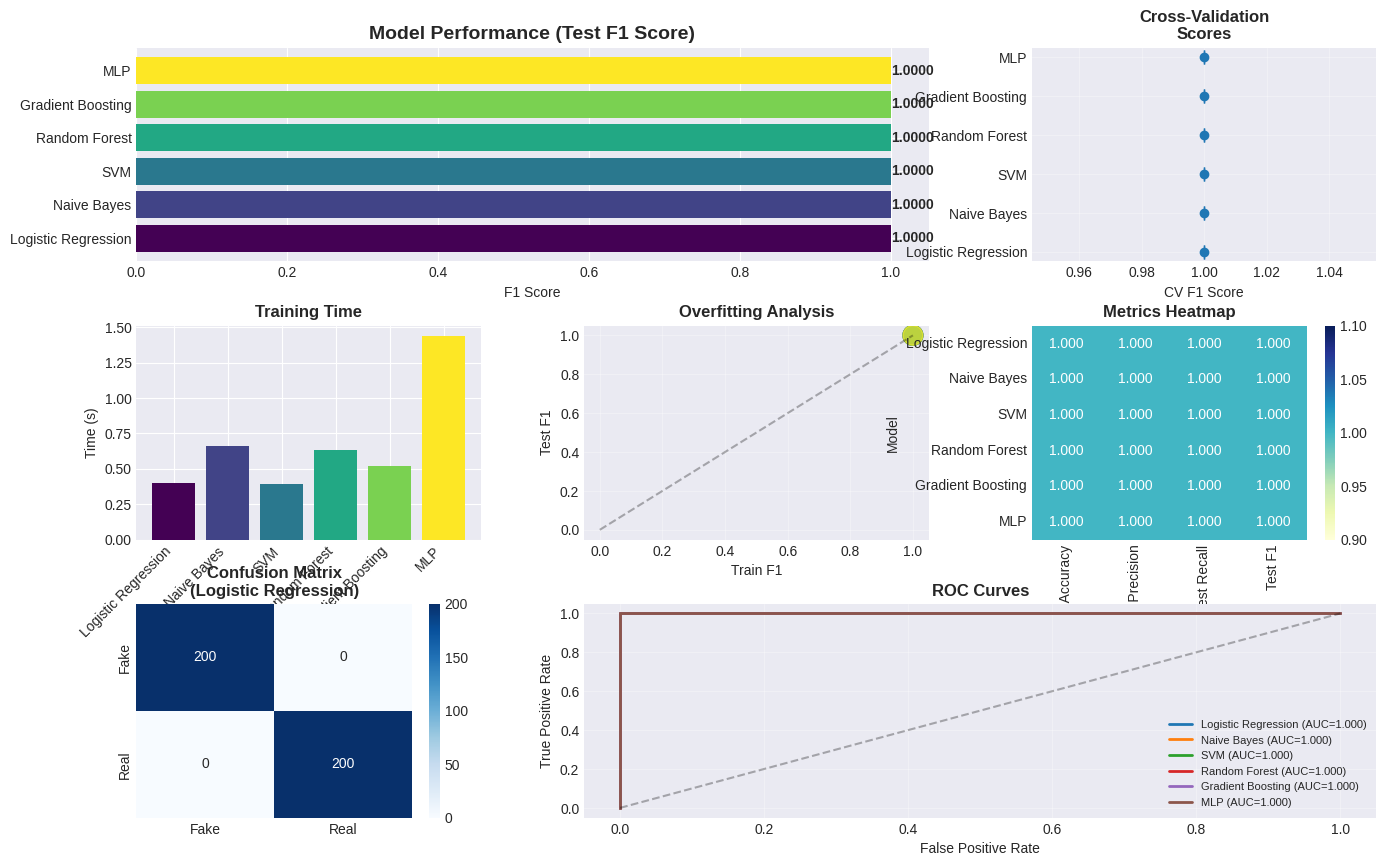

In [15]:

# =====================================================
# MODEL EVALUATION FRAMEWORK
# =====================================================

# =====================================================
# EVALUATION UTILITIES
# =====================================================

def evaluate_model(name, model, X_train, X_test, y_train, y_test, cv_strategy):
    """Comprehensive model evaluation with cross-validation"""
    print(f"\nEvaluating: {name}...")

    # Training
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy,
                                scoring='f1_macro', n_jobs=-1)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    metrics = {
        'Model': name,
        'CV F1 Mean': cv_scores.mean(),
        'CV F1 Std': cv_scores.std(),
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Train F1': f1_score(y_train, y_train_pred, average='macro'),
        'Test F1': f1_score(y_test, y_test_pred, average='macro'),
        'Test Precision': precision_score(y_test, y_test_pred, average='macro'),
        'Test Recall': recall_score(y_test, y_test_pred, average='macro'),
        'Test ROC-AUC': roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None,
        'Training Time (s)': train_time,
        'Overfitting Gap': f1_score(y_train, y_train_pred, average='macro') - f1_score(y_test, y_test_pred, average='macro')
    }

    print(f"  ✓ CV F1: {metrics['CV F1 Mean']:.4f} ± {metrics['CV F1 Std']:.4f}")
    print(f"  ✓ Test F1: {metrics['Test F1']:.4f} | Accuracy: {metrics['Test Accuracy']:.4f}")
    print(f"  ✓ Training Time: {train_time:.2f}s | Overfitting: {metrics['Overfitting Gap']:.4f}")

    return metrics, y_test_pred, y_test_proba

def create_model_pipelines():
    """Define all model pipelines"""
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 min_df=2, max_df=0.8)

    models = {
        'Logistic Regression': Pipeline([
            ('tfidf', vectorizer),
            ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
        ]),
        'Naive Bayes': Pipeline([
            ('tfidf', vectorizer),
            ('clf', MultinomialNB())
        ]),
        'SVM': Pipeline([
            ('tfidf', vectorizer),
            ('clf', SVC(kernel='linear', probability=True, random_state=RANDOM_STATE))
        ]),
        'Random Forest': Pipeline([
            ('tfidf', vectorizer),
            ('clf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
        ]),
        'Gradient Boosting': Pipeline([
            ('tfidf', vectorizer),
            ('clf', GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE))
        ]),
        'MLP': Pipeline([
            ('tfidf', vectorizer),
            ('clf', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=RANDOM_STATE))
        ]),
    }
    return models

def visualize_results(results_df, all_predictions, y_test):
    """Create comprehensive results visualization"""
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. F1 Score comparison
    ax1 = fig.add_subplot(gs[0, :2])
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
    bars = ax1.barh(results_df['Model'], results_df['Test F1'], color=colors)
    ax1.set_xlabel('F1 Score')
    ax1.set_title('Model Performance (Test F1 Score)', fontweight='bold', fontsize=14)
    for i, bar in enumerate(bars):
        ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                f'{bar.get_width():.4f}', ha='left', va='center', fontweight='bold')

    # 2. CV scores with error bars
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.errorbar(results_df['CV F1 Mean'], range(len(results_df)),
                xerr=results_df['CV F1 Std'], fmt='o', capsize=5)
    ax2.set_yticks(range(len(results_df)))
    ax2.set_yticklabels(results_df['Model'])
    ax2.set_xlabel('CV F1 Score')
    ax2.set_title('Cross-Validation\nScores', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # 3. Training time
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.bar(range(len(results_df)), results_df['Training Time (s)'], color=colors)
    ax3.set_xticks(range(len(results_df)))
    ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax3.set_ylabel('Time (s)')
    ax3.set_title('Training Time', fontweight='bold')

    # 4. Overfitting analysis
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.scatter(results_df['Train F1'], results_df['Test F1'], s=200, alpha=0.6, c=colors)
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax4.set_xlabel('Train F1')
    ax4.set_ylabel('Test F1')
    ax4.set_title('Overfitting Analysis', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # 5. Metrics heatmap
    ax5 = fig.add_subplot(gs[1, 2])
    metrics_hm = results_df[['Model', 'Test Accuracy', 'Test Precision',
                             'Test Recall', 'Test F1']].set_index('Model')
    sns.heatmap(metrics_hm, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax5)
    ax5.set_title('Metrics Heatmap', fontweight='bold')

    # 6. Confusion matrix (best model)
    best_model = results_df.iloc[0]['Model']
    ax6 = fig.add_subplot(gs[2, 0])
    cm = confusion_matrix(y_test, all_predictions[best_model]['pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax6,
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    ax6.set_title(f'Confusion Matrix\n({best_model})', fontweight='bold')

    # 7. ROC curves
    ax7 = fig.add_subplot(gs[2, 1:])
    for name in results_df['Model']:
        if all_predictions[name]['proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, all_predictions[name]['proba'])
            auc = roc_auc_score(y_test, all_predictions[name]['proba'])
            ax7.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)
    ax7.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax7.set_xlabel('False Positive Rate')
    ax7.set_ylabel('True Positive Rate')
    ax7.set_title('ROC Curves', fontweight='bold')
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3)

    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# =====================================================
# RUN MODEL EXPERIMENTS
# =====================================================

print("\n" + "="*60)
print("AUTOMATED MODEL EVALUATION")
print("="*60)
print("\nPrimary Metric: F1-Score (balances precision & recall)")
print("Cross-Validation: 5-fold stratified")

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
models = create_model_pipelines()
results = []
all_predictions = {}

# Evaluate all models
for name, model in models.items():
    metrics, y_pred, y_proba = evaluate_model(
        name, model, X_train, X_test, y_train, y_test, cv_strategy
    )
    results.append(metrics)
    all_predictions[name] = {'pred': y_pred, 'proba': y_proba}

# Results summary
results_df = pd.DataFrame(results).sort_values('Test F1', ascending=False)
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(results_df[['Model', 'CV F1 Mean', 'Test F1', 'Test Accuracy',
                  'Training Time (s)', 'Overfitting Gap']].to_string(index=False))

results_df.to_csv('model_results.csv', index=False)
visualize_results(results_df, all_predictions, y_test)




In [16]:
# =====================================================
# HYPERPARAMETER TUNING & ENSEMBLE
# =====================================================

# =====================================================
# HYPERPARAMETER TUNING
# =====================================================

def get_param_grid(model_name):
    """Get hyperparameter grid for each model"""
    grids = {
        'Logistic Regression': {
            'tfidf__max_features': [3000, 5000, 10000],
            'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
            'clf__C': [0.1, 1.0, 10.0]
        },
        'Naive Bayes': {
            'tfidf__max_features': [3000, 5000, 10000],
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'clf__alpha': [0.1, 0.5, 1.0, 2.0]
        },
        'SVM': {
            'tfidf__max_features': [3000, 5000],
            'tfidf__ngram_range': [(1, 1), (1, 2)],
            'clf__C': [0.1, 1.0, 10.0]
        },
        'Random Forest': {
            'tfidf__max_features': [3000, 5000],
            'clf__n_estimators': [100, 200],
            'clf__max_depth': [None, 50, 100]
        },
        'Gradient Boosting': {
            'tfidf__max_features': [3000, 5000],
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1]
        }
    }
    return grids.get(model_name, {})

def tune_model(model_name, base_model, X_train, y_train, cv_strategy):
    """Tune hyperparameters using RandomizedSearchCV"""
    param_grid = get_param_grid(model_name)

    if not param_grid:
        print(f"No tuning grid for {model_name}")
        return base_model, {}

    print(f"\nTuning {model_name}...")
    print(f"Parameters: {list(param_grid.keys())}")

    search = RandomizedSearchCV(
        base_model, param_grid, n_iter=15, cv=cv_strategy,
        scoring='f1_macro', n_jobs=-1, random_state=RANDOM_STATE, verbose=0
    )
    search.fit(X_train, y_train)

    print(f"✓ Best CV F1: {search.best_score_:.4f}")
    print(f"  Best params: {search.best_params_}")

    return search.best_estimator_, search.best_params_

# =====================================================
# TUNE BEST MODEL
# =====================================================

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

best_model_name = results_df.iloc[0]['Model']
print(f"Selected: {best_model_name}")

base_model = models[best_model_name]
tuned_model, best_params = tune_model(
    best_model_name, base_model, X_train, y_train, cv_strategy
)

# Evaluate tuned model
tuned_metrics, tuned_pred, tuned_proba = evaluate_model(
    f"{best_model_name} (Tuned)", tuned_model,
    X_train, X_test, y_train, y_test, cv_strategy
)

# Compare before/after
original = results_df.iloc[0]
comparison = pd.DataFrame({
    'Metric': ['Test F1', 'Test Accuracy', 'CV F1', 'Overfitting Gap'],
    'Before': [original['Test F1'], original['Test Accuracy'],
               original['CV F1 Mean'], original['Overfitting Gap']],
    'After': [tuned_metrics['Test F1'], tuned_metrics['Test Accuracy'],
              tuned_metrics['CV F1 Mean'], tuned_metrics['Overfitting Gap']]
})
comparison['Improvement'] = comparison['After'] - comparison['Before']

print("\n" + "="*60)
print("TUNING IMPACT")
print("="*60)
print(comparison.to_string(index=False))

# =====================================================
# ENSEMBLE MODEL (EXCELLENCE)
# =====================================================

print("\n" + "="*60)
print("ENSEMBLE MODEL (Excellence Criteria)")
print("="*60)

# Top 3 models
top_3 = results_df.head(3)['Model'].tolist()
print(f"Combining: {top_3}")

ensemble_estimators = [(name.replace(' ', '_'), models[name]) for name in top_3]
ensemble_model = VotingClassifier(estimators=ensemble_estimators, voting='soft', n_jobs=-1)

ensemble_metrics, ensemble_pred, ensemble_proba = evaluate_model(
    "Ensemble (Top 3)", ensemble_model, X_train, X_test, y_train, y_test, cv_strategy
)

# Final comparison
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)

final_comparison = pd.DataFrame({
    'Model': [best_model_name, f'{best_model_name} (Tuned)', 'Ensemble'],
    'Test F1': [original['Test F1'], tuned_metrics['Test F1'], ensemble_metrics['Test F1']],
    'Test Accuracy': [original['Test Accuracy'], tuned_metrics['Test Accuracy'],
                      ensemble_metrics['Test Accuracy']],
    'ROC-AUC': [original['Test ROC-AUC'], tuned_metrics['Test ROC-AUC'],
                ensemble_metrics['Test ROC-AUC']]
})
print(final_comparison.to_string(index=False))

# Save final model info
print("\n✓ Best performing model:", final_comparison.loc[final_comparison['Test F1'].idxmax(), 'Model'])
print(f"✓ Final F1 Score: {final_comparison['Test F1'].max():.4f}")
print(f"✓ Final Accuracy: {final_comparison['Test Accuracy'].max():.4f}")





HYPERPARAMETER TUNING
Selected: Logistic Regression

Tuning Logistic Regression...
Parameters: ['tfidf__max_features', 'tfidf__ngram_range', 'clf__C']
✓ Best CV F1: 1.0000
  Best params: {'tfidf__ngram_range': (1, 3), 'tfidf__max_features': 10000, 'clf__C': 0.1}

Evaluating: Logistic Regression (Tuned)...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 0.56s | Overfitting: 0.0000

TUNING IMPACT
         Metric  Before  After  Improvement
        Test F1     1.0    1.0          0.0
  Test Accuracy     1.0    1.0          0.0
          CV F1     1.0    1.0          0.0
Overfitting Gap     0.0    0.0          0.0

ENSEMBLE MODEL (Excellence Criteria)
Combining: ['Logistic Regression', 'Naive Bayes', 'SVM']

Evaluating: Ensemble (Top 3)...
  ✓ CV F1: 1.0000 ± 0.0000
  ✓ Test F1: 1.0000 | Accuracy: 1.0000
  ✓ Training Time: 1.12s | Overfitting: 0.0000

FINAL MODEL COMPARISON
                      Model  Test F1  Test Accuracy  ROC-AUC
        Logistic R


CLASSIFICATION REPORT: Best Model
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00       200
   Real News       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


CLASSIFICATION REPORT: Tuned Model
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00       200
   Real News       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


CLASSIFICATION REPORT: Ensemble
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00       200
   Real News       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00 

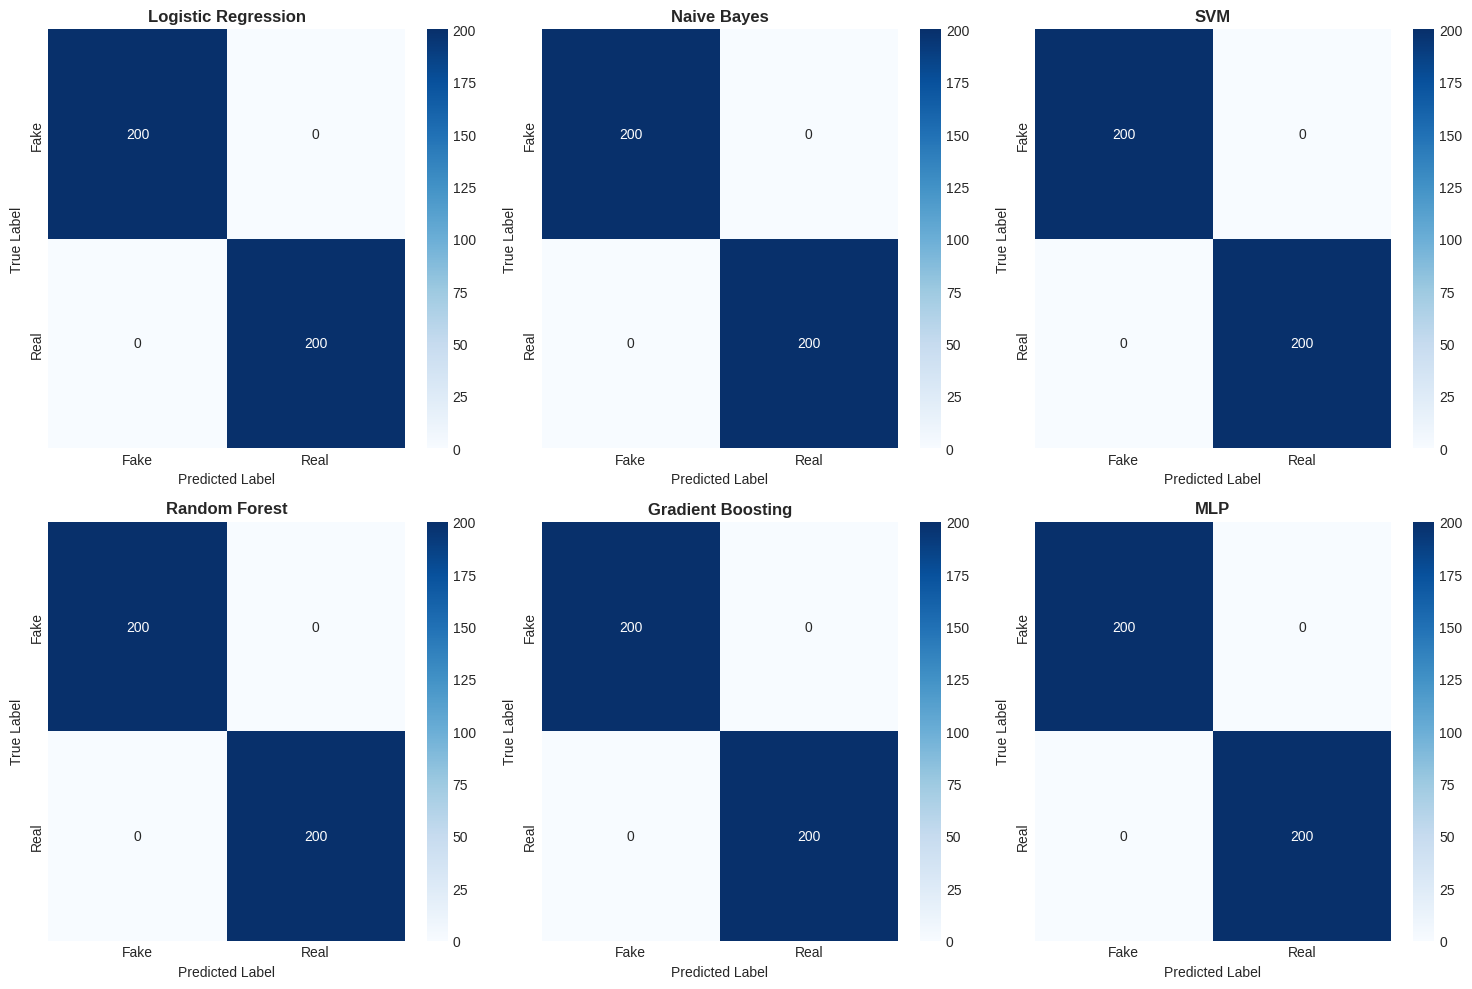


PROJECT SUMMARY REPORT

1. EXPERIMENT OVERVIEW
   - Models tested: 6
   - Cross-validation: 5-fold stratified
   - Primary metric: F1-Score (macro)

2. BEST BASELINE MODEL
   - Model: Logistic Regression
   - Test F1: 1.0000
   - Test Accuracy: 1.0000
   - Training Time: 0.40s

3. AFTER HYPERPARAMETER TUNING
   - Test F1: 1.0000 (+0.0000)
   - Test Accuracy: 1.0000 (+0.0000)

4. ENSEMBLE MODEL
   - Test F1: 1.0000
   - Test Accuracy: 1.0000
   - ROC-AUC: 1.0000

5. OVERFITTING/UNDERFITTING ANALYSIS
   - Logistic Regression: Gap=0.0000 (Good)
   - Naive Bayes: Gap=0.0000 (Good)
   - SVM: Gap=0.0000 (Good)
   - Random Forest: Gap=0.0000 (Good)
   - Gradient Boosting: Gap=0.0000 (Good)
   - MLP: Gap=0.0000 (Good)

6. MODEL EFFICIENCY
   - Fastest: SVM (0.39s)
   - F1 vs Time tradeoff: Consider for production deployment



In [18]:
# =====================================================
# DETAILED ANALYSIS & REPORTING
# =====================================================

# =====================================================
# DETAILED PERFORMANCE ANALYSIS
# =====================================================

def generate_classification_report(model_name, y_true, y_pred):
    """Generate detailed classification report"""
    print(f"\n{'='*60}")
    print(f"CLASSIFICATION REPORT: {model_name}")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=['Fake News', 'Real News']))

def plot_confusion_matrices(predictions_dict, y_test):
    """Plot confusion matrices for all models"""
    n_models = len(predictions_dict)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (name, preds) in enumerate(predictions_dict.items()):
        if idx >= len(axes):
            break
        cm = confusion_matrix(y_test, preds['pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
        axes[idx].set_title(name, fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    # Hide extra subplots
    for idx in range(len(predictions_dict), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('confusion_matrices_all.png', dpi=300, bbox_inches='tight')
    plt.show()

def generate_summary_report(results_df, tuned_metrics, ensemble_metrics):
    """Generate final summary report"""
    print("\n" + "="*60)
    print("PROJECT SUMMARY REPORT")
    print("="*60)

    print("\n1. EXPERIMENT OVERVIEW")
    print(f"   - Models tested: {len(results_df)}")
    print(f"   - Cross-validation: 5-fold stratified")
    print(f"   - Primary metric: F1-Score (macro)")

    print("\n2. BEST BASELINE MODEL")
    best = results_df.iloc[0]
    print(f"   - Model: {best['Model']}")
    print(f"   - Test F1: {best['Test F1']:.4f}")
    print(f"   - Test Accuracy: {best['Test Accuracy']:.4f}")
    print(f"   - Training Time: {best['Training Time (s)']:.2f}s")

    print("\n3. AFTER HYPERPARAMETER TUNING")
    print(f"   - Test F1: {tuned_metrics['Test F1']:.4f} ({tuned_metrics['Test F1']-best['Test F1']:+.4f})")
    print(f"   - Test Accuracy: {tuned_metrics['Test Accuracy']:.4f} ({tuned_metrics['Test Accuracy']-best['Test Accuracy']:+.4f})")

    print("\n4. ENSEMBLE MODEL")
    print(f"   - Test F1: {ensemble_metrics['Test F1']:.4f}")
    print(f"   - Test Accuracy: {ensemble_metrics['Test Accuracy']:.4f}")
    print(f"   - ROC-AUC: {ensemble_metrics['Test ROC-AUC']:.4f}")

    print("\n5. OVERFITTING/UNDERFITTING ANALYSIS")
    for _, row in results_df.iterrows():
        gap = row['Overfitting Gap']
        status = 'Good' if gap < 0.05 else 'Moderate' if gap < 0.1 else 'High'
        print(f"   - {row['Model']}: Gap={gap:.4f} ({status})")

    print("\n6. MODEL EFFICIENCY")
    fastest = results_df.loc[results_df['Training Time (s)'].idxmin()]
    print(f"   - Fastest: {fastest['Model']} ({fastest['Training Time (s)']:.2f}s)")
    print(f"   - F1 vs Time tradeoff: Consider for production deployment")

    print("\n" + "="*60)

# =====================================================
# GENERATE DETAILED REPORTS
# =====================================================

# Classification reports for top models
generate_classification_report("Best Model", y_test, all_predictions[best_model_name]['pred'])
generate_classification_report("Tuned Model", y_test, tuned_pred)
generate_classification_report("Ensemble", y_test, ensemble_pred)

# All confusion matrices
plot_confusion_matrices(all_predictions, y_test)

# Final summary
generate_summary_report(results_df, tuned_metrics, ensemble_metrics)

